In [1]:
from scipy import *
import numpy as np
from pylab import *
from scipy.interpolate import interp1d
import os
from astropy.io import fits
from scipy.special import factorial
%matplotlib inline

# Set Fiducial Cosmology Parameters

In [2]:
######## check TT, Pk (z=0), Clkk (z=1) from class vs camb

# LCDM parameters
A_s = 2.1e-9
h=0.7
OmegaB = 0.046
OmegaM = 0.3
n_s = 0.97
tau = 0.054 ## only for primary CMB, not used for now, for simplicity

# beyond LCDM, not implemented yet
OmegaDE = 0.75
w0=-1.0#-0.5#
wa=0.0#0.1#
Neff = 3.046
mnu = 0.0

### derived parameters
#z_reio = 10.0 #11.357
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100
### accuracy parameters
lmax=5000

# CLASS for TT, Pk, Clkk

In [3]:
##########################
####### class ############
##########################

## https://github.com/lesgourg/class_public/blob/master/explanatory.ini
# 1.a) list of output spectra requested:
# - 'tCl' for temperature Cls,
# - 'pCl' for polarization Cls,
# - 'lCl' for CMB lensing potential Cls,
# - 'nCl' (or 'dCl') for density number count Cls,
# - 'sCl' for galaxy lensing potential Cls,
# - 'mPk' for total matter power spectrum P(k) infered from gravitational potential,
# - 'dTk' (or 'mTk') for density transfer functions for each species,
# - 'vTk' for velocity transfer function for each species.

# import classy module
from classy import Class
# create instance of the class "Class"
LambdaCDM = Class()
LambdaCDM.set({'omega_b':ombh2,'omega_cdm':omch2,'h':h,'A_s':A_s,'n_s':n_s})
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk,sCl',
               #'lensing':'yes',
               'lensing':'no',
               'P_k_max_1/Mpc':10.0,
               'z_pk':0,
               'reio_parametrization':'reio_none',
               #'z_reio':10.0, 'tau_reio':tau
               'l_switch_limber':100,
               'selection':'dirac',
               'selection_mean':1.0,
               'l_max_lss':lmax,
               'perturb_sampling_stepsize':0.01})
# run class
LambdaCDM.compute()

In [4]:
si8=LambdaCDM.sigma8()

In [5]:
# get all C_l output
#cls = LambdaCDM.lensed_cl(2500)
cls = LambdaCDM.raw_cl()
print cls.viewkeys()
ll = cls['ell'][2:]
clTT = cls['tt'][2:]
#clEE = cls['ee'][2:]
#clPP = cls['pp'][2:]

dict_keys(['pp', 'ell', 'bb', 'ee', 'tt', 'tp', 'te'])


In [6]:
# get P(k) at redhsift z=0
kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk.append(LambdaCDM.pk(k*h,0.)*h**3) # function .pk(k,z)

In [16]:
# get Clkk
cls2=LambdaCDM.density_cl(lmax)
print cls2.viewkeys()
ell=cls2['ell'][2:]
clphiphi=cls2['ll'][0][2:]
#clkk=1.0/4 * ((l+2.0)!/(l-2.0)!)* clphiphi
#clkk=1.0/4 * (factorial(ell+2.0)/factorial(ell-2.0))*clphiphi
clkk=1.0/4 * (ell+2.0)*(ell+1.0)*(ell)*(ell-1.0)*clphiphi
#print type(clkk)

dict_keys(['ll', 'ell'])


# CAMB for TT, Pk, Clkk

In [8]:
##########################
####### camb #############
##########################

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, omk=0, 
                   tau=0, mnu=mnu, neutrino_hierarchy='normal')
### dark energy ##########
pars.set_dark_energy(w=w0, wa=wa, dark_energy_model='fluid') 

pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
pars.set_matter_power(redshifts=[0.,], kmax=10.0)
pars.set_for_lmax(lmax, lens_potential_accuracy=0);
pars.SourceWindows = [camb.sources.GaussianSourceWindow(redshift=1.0, source_type='lensing', sigma=0.0001),]

#calculate results for these parameters
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
for name in powers: print(name)

Using CAMB 1.0.3 installed at /Users/jia/anaconda/lib/python2.7/site-packages/camb
total
lens_potential
lensed_scalar
unlensed_scalar
unlensed_total
tensor


In [9]:
## primary CMB
unlensedCL=powers['unlensed_scalar'][:,0]
ls = np.arange(unlensedCL.shape[0])

## Pk
kcamb, zcamb, Pkcamb = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 200)
print zcamb,kcamb.shape, Pkcamb.shape

## Clkk
cls_Wz = results.get_source_cls_dict()
for name in cls_Wz: print(name)
clkk_camb = cls_Wz['W1xW1'][2:]
ls2=  np.arange(2, len(clkk_camb)+2)
#print type(clkk_camb),type(ls2)

[0.0] (200,) (1, 200)
PxW1
W1xP
PxP
W1xW1


# CLASS vs CAMB comparison plots: TT, Pk, Clkk

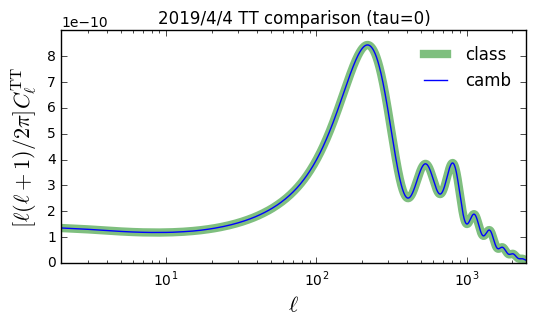

In [10]:
# plot C_l^TT
figure(1, figsize=(6,3))
xscale('log');plt.yscale('linear');plt.xlim(2,2500)
xlabel(r'$\ell$',fontsize=16)
ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$',fontsize=16)
plot(ll,clTT*ll*(ll+1)/2./pi,'g-',lw=6,alpha=0.5,label='class')
plot(ls,unlensedCL/2.725**2,'b-',label='camb')
legend(loc=0,frameon=0)
title('2019/4/4 TT comparison (tau=0)')

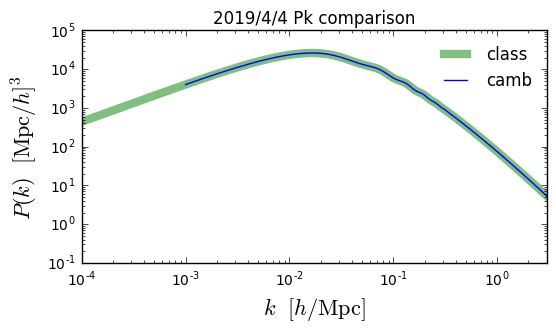

In [11]:
# plot P(k)
figure(2, figsize=(6,3))
xscale('log');plt.yscale('log');plt.xlim(kk[0],kk[-1])
xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=16)
ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=16)
plot(kk,Pk,'g-',lw=6,alpha=0.5,label='class')
plot(kcamb,Pkcamb[0],'b-',label='camb')
title('2019/4/4 Pk comparison')
legend(loc=0,frameon=0)

In [12]:
#print type(ell),ell.shape, clkk.shape,ls2.shape, clkk_camb.shape

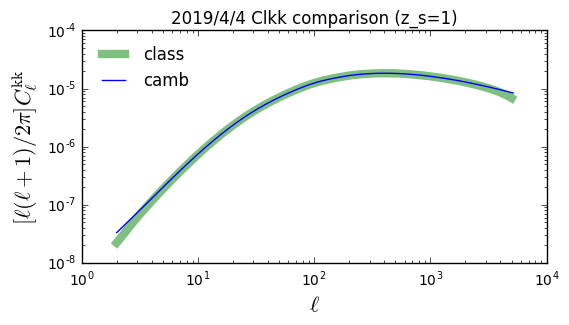

In [17]:
# plot C_l^TT
figure(3, figsize=(6,3))
xscale('log');yscale('log');#xlim(2,2500)
xlabel(r'$\ell$',fontsize=16)
ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$',fontsize=16)
plot(ell,clkk*ell*(ell+1)/2./pi,'g-',lw=6,alpha=0.5,label='class')
plot(ls2, clkk_camb,'b-',label='camb')
legend(loc=0,frameon=0)
title('2019/4/4 Clkk comparison (z_s=1)')

# Test HMF

In [14]:
######################################
############## HMF ###################
######################################

mbins = arange(11, 15.5, 0.1)

## murray
import hmf
import astropy.units as u
HMF = hmf.MassFunction(cosmo_params={"Ob0":OmegaB, "H0":H0, "Om0":OmegaM, 
       "m_nu":array([0,0,0])*u.eV},z=0, sigma_8=si8,
        Mmin=11, Mmax=15.5, dlog10m=0.1, n=n_s, delta_wrt='mean',
       hmf_model=hmf.fitting_functions.Tinker08)

## diemer
## https://bdiemer.bitbucket.io/colossus/#citing-colossus
from colossus.cosmology import cosmology as cosmo
from colossus.lss import mass_function
cosmo.setCosmology('myCosmo',{'flat': True, 'H0': H0, 'Om0': OmegaM, 
                              'Ob0': OmegaB, 'sigma8': si8, 'ns': n_s,'Ode0':OmegaDE,
                              'de_model':'w0wa','w0':w0,'wa':wa})
# mfunc_so = mass_function.massFunction(10**mbins, 0.0, mdef = '200c', model = 'tinker08',q_out = 'dndlnM')
# mfunc_fof = mass_function.massFunction(10**mbins, 0.0, mdef = '200c', model = 'watson13',q_out = 'dndlnM')
mfunc_so = mass_function.massFunction(10**mbins, 0.0, mdef = 'vir', model = 'tinker08',q_out = 'dndlnM')
mfunc_fof = mass_function.massFunction(10**mbins, 0.0, mdef = 'fof', model = 'watson13',q_out = 'dndlnM')

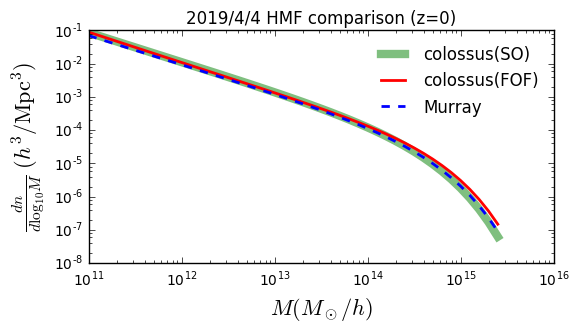

In [15]:
figure(4, figsize=(6,3))
xscale('log');yscale('log');#xlim(2,2500)

plot(10**mbins, mfunc_so/h**3,'g-',lw=6,alpha=0.5,label='colossus(SO)')
plot(10**mbins, mfunc_fof/h**3,'r-',lw=2,alpha=1,label='colossus(FOF)')
plot(10**mbins, HMF.dndlog10m,'b--',lw=2,label='Murray')
xlabel(r'$M (M_\odot/h)$',fontsize=16)
ylabel(r'$\frac{dn} {d\log_{10}M} \; (h^3/{\rm Mpc}^3)$',fontsize=16)
legend(loc=0,frameon=0)
title('2019/4/4 HMF comparison (z=0)')

# Function to generate all 4 observables for LCDM

In [47]:
def obsGen (A_s=A_s, h=h, OmegaB=OmegaB, OmegaM=OmegaM, n_s=n_s, mnu=0, mbins = arange(11, 15.5, 0.1)):
    ##### TT, Pk, Clkk
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h*100.0, ombh2=OmegaB*h**2, omch2=(OmegaM-OmegaB)*h**2, omk=0, 
                   tau=0, mnu=mnu, neutrino_hierarchy='normal')
    pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
    pars.set_matter_power(redshifts=[0.,], kmax=10.0)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0);
    pars.SourceWindows = [camb.sources.GaussianSourceWindow(redshift=1.0, source_type='lensing', sigma=0.0001),]
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
    
    ## primary CMB
    unlensedCL=powers['unlensed_scalar'][:,0]
    ls = np.arange(unlensedCL.shape[0])
    
    ## Pk
    kcamb, zcamb, Pkcamb = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 200)
    #print zcamb,kcamb.shape, Pkcamb.shape

    ## Clkk
    cls_Wz = results.get_source_cls_dict()
    clkk_camb = cls_Wz['W1xW1'][2:]
    ls2=  np.arange(2, len(clkk_camb)+2)
    
    si8=results.get_sigma8()
    ## HMF
    cosmo.setCosmology('myCosmo',{'flat': True, 'H0': h*100.0, 'Om0': OmegaM, 
                              'Ob0': OmegaB, 'sigma8': si8, 'ns': n_s})
                                  #'Ode0':OmegaDE,'de_model':'w0wa','w0':w0,'wa':wa})
    mfunc_so = mass_function.massFunction(10**mbins, 0.0, mdef = 'vir', model = 'tinker08',q_out = 'dndlnM')
    return [ls, unlensedCL/2.725**2], [kcamb, Pkcamb[0]], [ls2, clkk_camb], [mbins, mfunc_so/h**3]

In [78]:
def plotLCDM (f, axes, out, c='g',ilabel=''):    
    il, iclTT = out[0]
    ik, iPk = out[1]
    il2, iclkk = out[2]
    mbins, ihmf = out[3]
    #axes=[ [axes0[0],axes0[1]],[axes0[2],axes0[3]]]
    
    axes[0][0].set_xscale('log');
    axes[0][0].set_yscale('linear');
    axes[0][0].set_xlim(2,2500)
    axes[0][0].set_xlabel(r'$\ell$',fontsize=12)
    axes[0][0].set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$',fontsize=12)
    axes[0][0].plot(il,iclTT,'-',color=c,label=ilabel)
    

    axes[0][1].set_xscale('log');
    axes[0][1].set_yscale('log');
    axes[0][1].set_xlim(ik[0],ik[-1])
    axes[0][1].set_xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=12)
    axes[0][1].set_ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=12)
    axes[0][1].plot(ik,iPk,'-',color=c,label=ilabel)

    axes[1][0].set_xscale('log');
    axes[1][0].set_yscale('log');
    axes[1][0].set_xlim(2,lmax)
    axes[1][0].set_xlabel(r'$\ell$',fontsize=12)
    axes[1][0].set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{kk}$',fontsize=12)
    axes[1][0].plot(il2,iclkk,'-',color=c,label=ilabel)

    axes[1][1].set_xscale('log');
    axes[1][1].set_yscale('log');
    axes[1][1].plot(10**mbins,ihmf,'-',color=c,label=ilabel)
    axes[1][1].set_xlim(1e11,1e16)
    axes[1][1].set_xlabel(r'$M (M_\odot/h)$',fontsize=12)
    axes[1][1].set_ylabel(r'$\frac{dn} {d\log_{10}M} \; (h^3/{\rm Mpc}^3)$',fontsize=12)

In [93]:
######### test function by plotting
#out0=obsGen()
#out1=obsGen(h=0.6)
# f, axes=subplots(2,2,figsize=(8,4))
# plotLCDM(f, axes, out0, c='g',ilabel='h=0.7')
# plotLCDM(f, axes, out1, c='b',ilabel='h=0.6')
# axes[0][0].legend(loc=0,frameon=0,fontsize=8)
# axes[0][1].legend(loc=0,frameon=0,fontsize=8)
# axes[1][0].legend(loc=0,frameon=0,fontsize=8)
# axes[1][1].legend(loc=0,frameon=0,fontsize=8)
# plt.tight_layout()

# Test observable change for each param

In [94]:
####### test looping over an array of parameters, h here
# f, axes=subplots(2,2,figsize=(8,4))
# h_arr = arange(0.6,0.8,0.05)
# colors = plt.cm.Purples(np.linspace(0.3,0.8,len(h_arr)))
# out_arr=[obsGen(h=ih) for ih in h_arr]
# for i in range(len(h_arr)): plotLCDM(f, axes, out_arr[i], c=colors[i], ilabel='h=%.2f'%(h_arr[i]))
# axes[0][0].legend(loc='upper left',frameon=0,fontsize=8)
# plt.tight_layout()

In [82]:
################ takes a long time to run ##################
# As_arr = arange(1.8,2.4,0.1)
# h_arr = arange(0.6,0.8,0.05)
# om_arr = arange(0.25, 0.35, 0.02)
# ob_arr = arange(0.035, 0.055, 0.004)
# ns_arr = arange(0.92, 1.01, 0.02)

# labels=['As','h','OmegaM','OmegaB','ns']
# out_arr = [[obsGen(A_s=ix*1e-9) for ix in As_arr],
#            [obsGen(h=ix) for ix in h_arr],
#           [obsGen(OmegaM=ix) for ix in om_arr],
#           [obsGen(OmegaB=ix) for ix in ob_arr],
#           [obsGen(n_s=ix) for ix in ns_arr]]

# save('obsGen.npy',out_arr)

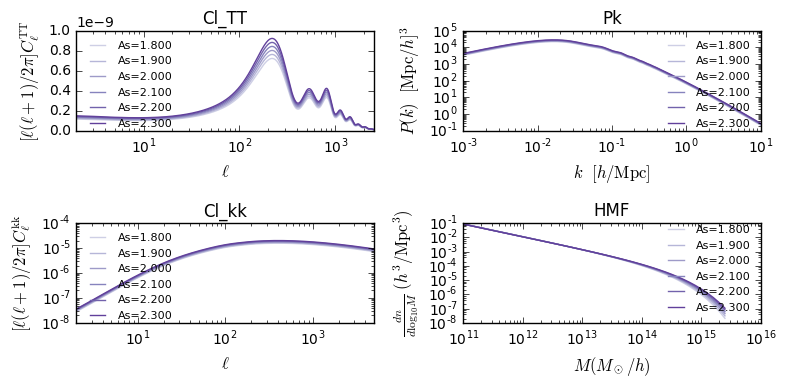

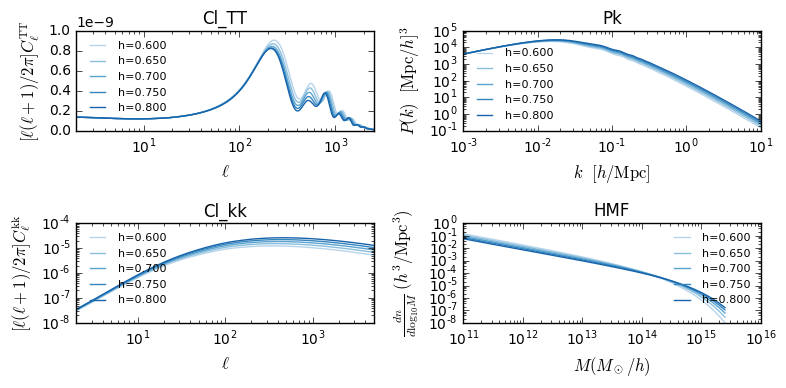

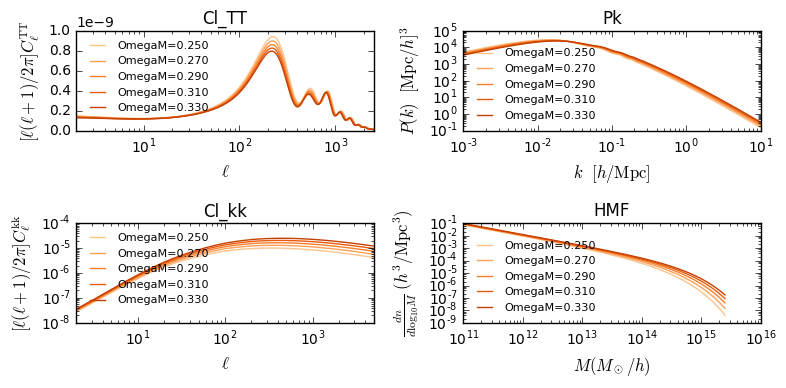

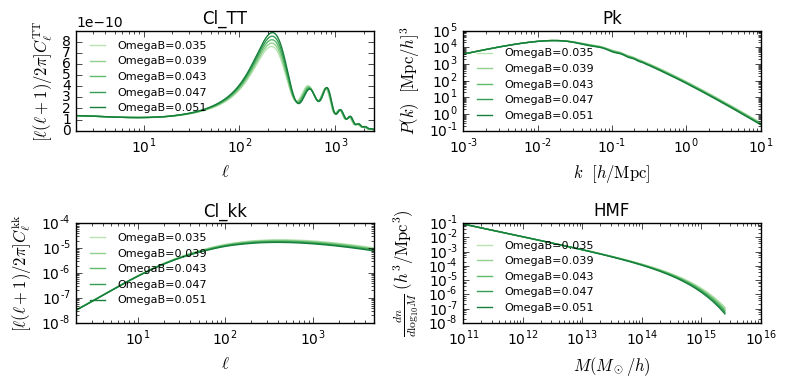

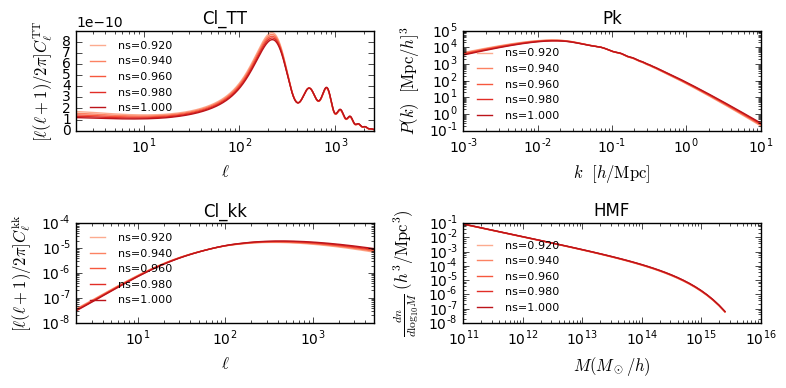

In [92]:
#out_arr = load('obsGen.npy')

param_arr = [As_arr, h_arr, om_arr, ob_arr, ns_arr]
labels=['As','h','OmegaM','OmegaB','ns']
colors_arr = [plt.cm.Purples, plt.cm.Blues, plt.cm.Oranges, plt.cm.Greens, plt.cm.Reds]

for j in range(5):
    iparam=param_arr[j]
    ilabel=labels[j]
    iout_arr=out_arr[j]
    f, axes=subplots(2,2,figsize=(8,4))
    colors = colors_arr[j](np.linspace(0.3,0.8,len(iparam)))
    for i in range(len(iparam)): plotLCDM(f, axes, iout_arr[i], c=colors[i], ilabel='%s=%.3f'%(ilabel, iparam[i]))
    for i in range(4): 
        iax=[axes[0][0],axes[0][1],axes[1][0],axes[1][1]][i]
        iax.set_title(['Cl_TT','Pk','Cl_kk','HMF'][i],fontsize=12)
        iax.legend(loc=0,frameon=0,fontsize=8)
    plt.tight_layout()

# Add parameters beyond LCDM